In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import sys # Ignore warnings
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/My Drive/SYSC5108 Deep Learning Project/Training Set/'
test_dir = '/content/drive/My Drive/SYSC5108 Deep Learning Project/Test Set/'
folders = os.listdir(train_dir)
print(folders)

['Rain', 'Shine', 'Cloudy', 'Sunrise']


In [ ]:
# Import necessary libraries and modules
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from keras.layers import Conv2D, Dropout, Dense, Flatten, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models

##Loading the dataset and preprocessing

In [ ]:
# Set the batch size and image size
batch_size = 32
img_size = 150
num_classes = 4
input_shape = (150, 150, 3)

np.random.seed(42)
tf.random.set_seed(42)

# Create an ImageDataGenerator for the training and validation sets
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25,  # set the validation split to 20%
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=20,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
)

# Create separate generators for the training and validation sets
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',  # set the subset to 'training' for the training set
    shuffle=True,  # shuffle the training set
    seed = 42
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # set the subset to 'validation' for the validation set
    shuffle= False,
    seed = 42
)

# Create an ImageDataGenerator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a generator for the test set
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    class_mode='categorical',
    shuffle=True,
    seed = 42  
)

Found 676 images belonging to 4 classes.
Found 224 images belonging to 4 classes.
Found 225 images belonging to 4 classes.


In [ ]:
train_generator.image_shape

(150, 150, 3)

## Defining the CNN model

In [ ]:
# Set the random seed for reproducibility
tf.random.set_seed(42)

def create_model(num_conv_layers, num_filters, filter_size, num_dense_layers, num_dense_units, dropout_rate):
    model = Sequential()
    # Add the first convolutional layer
    model.add(Conv2D(num_filters, filter_size, acti vation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    # Add additional convolutional layers
    for i in range(num_conv_layers - 1):
        model.add(Conv2D(num_filters, filter_size, activation='relu'))
        model.add(MaxPooling2D((2, 2)))
    # Flatten the output of the convolutional layers
    model.add(Flatten())
    # Add fully connected layers
    for i in range(num_dense_layers):
        model.add(Dense(num_dense_units, activation='relu'))
        model.add(Dropout(dropout_rate))
    # Add the output layer with softmax activation function
    model.add(Dense(num_classes, activation='softmax'))

    model.summary()

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## Hyperparameter tuning

In [ ]:
param_grid = {
    'num_conv_layers': [2],
    'num_filters': [32],
    'filter_size': [(3, 3)],
    'num_dense_layers': [1, 2],
    'num_dense_units': [32],
    'dropout_rate': [0.3, 0.5]
}

# Wrap the Keras model with scikit-learn's KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs = 10, batch_size=batch_size, verbose=2)

# Define a function to convert a generator to numpy arrays
def generator_to_array(generator):
    x = []
    y = []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        x.append(x_batch)
        y.append(y_batch)
    x = np.concatenate(x)
    y = np.concatenate(y)
    return x, y

# Convert the generator to numpy arrays
train_data, train_labels = generator_to_array(train_generator)
val_data, val_labels = generator_to_array(val_generator)

# Convert the generator to numpy arrays
train_data, train_labels = generator_to_array(train_generator)
val_data, val_labels = generator_to_array(val_generator)


# Perform grid search with cross-validation
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose = 2)

grid_result = grid.fit(val_data, val_labels)

# Train the model with the best hyperparameters
model = grid_result.best_estimator_.model
print("Best parameters: ", grid_result.best_params_)
history = model.fit(train_generator, epochs=15, validation_data=val_generator, verbose=2, workers=4)

<ipython-input-9-8ef3c7e393b2>:11: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs = 10, batch_size=batch_size, verbose=2)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 32)                1

## Model evaluation

8/8 [==============================] - 3s 342ms/step - loss: 0.4459 - accuracy: 0.8844
Test loss: 0.44590064883232117
Test accuracy: 0.8844444155693054
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


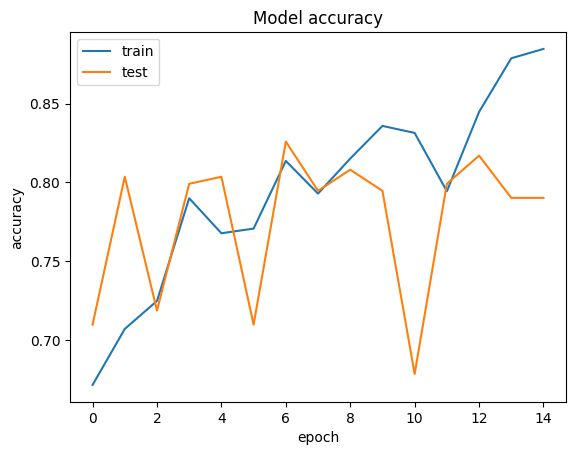

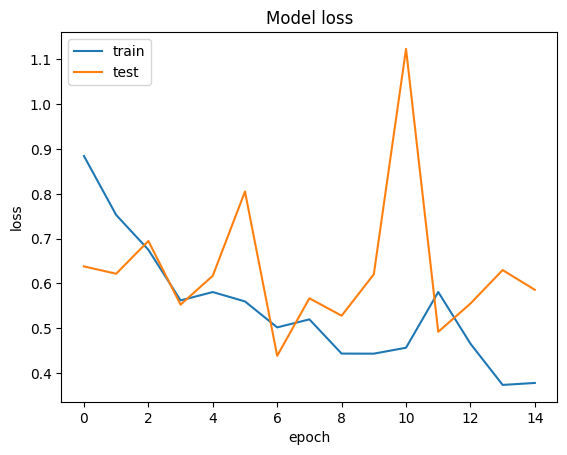

              precision    recall  f1-score   support

           0       0.91      0.87      0.89        60
           1       0.97      0.70      0.81        43
           2       0.75      0.98      0.85        51
           3       0.96      0.94      0.95        71

    accuracy                           0.88       225
   macro avg       0.90      0.87      0.87       225
weighted avg       0.90      0.88      0.88       225



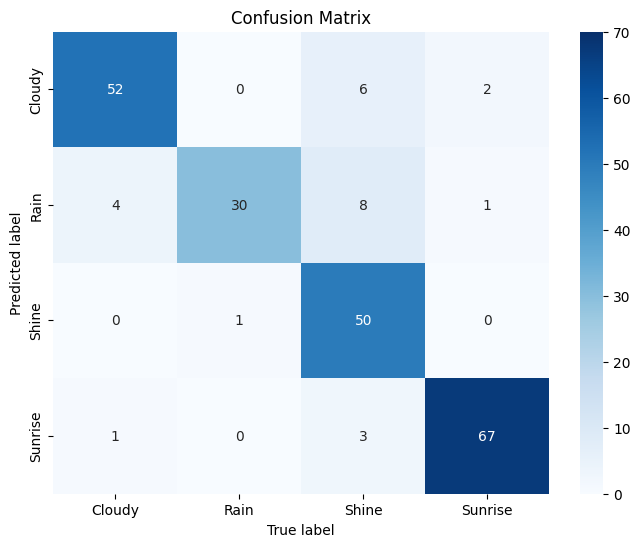

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(test_generator)

y_pred_categorical = np.argmax(y_pred, axis=1)
y_true_categorical = test_generator.classes

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
    
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Print classification report
print(classification_report(y_true_categorical, y_pred_categorical))

# Generate confusion matrix
cm = confusion_matrix(y_true_categorical, y_pred_categorical)

# Print confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues',vmin = 0, vmax = 70, xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()